#  Road Pixels in Satellite Imagery

In this notebook, I attempt to identify road pixels in one test satellite image by training a Logistic Regression model on another training satellite image. For some great research papers using more elaborate models to detect roads see: 
* [Mnih and Hinton 2010](http://www.cs.toronto.edu/~fritz/absps/road_detection.pdf)
* [Wang et al 2016](http://www.mdpi.com/2220-9964/5/7/114/htm#B4-ijgi-05-00114)
* [Zhang et al 2017](https://arxiv.org/pdf/1711.10684.pdf).

# Useful Functions

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
import numpy as np

In [7]:
def load_im(filename):
    '''load image'''
    im = mpimg.imread(filename)
    return im

def smooth(img, filter_type):
    '''smoothing filters'''
    if filter_type == "mean":
        return cv.blur(img, (5, 5))
    if filter_type == "gaussian":
        return cv.GaussianBlur(img, (5, 5), 0)
    
def transform(img, transform_type, kernel = np.ones((5, 5), np.uint8)):
    '''morphological transformations'''
    if transform_type == "erosion":
        return cv.erode(img, kernel, iterations = 1)
    if transform_type == "dilation":
        return cv.dilate(img, kernel, iterations = 1)
    if transform_type == "open":
        return cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    if transform_type == "close":
        return cv.morphologyEx(img, cv.MORPH_OPEN, kernel)

def augment(img):
    '''data augment image by flipping/rotating'''
    return [np.flipud(img), np.fliplr(img), np.rot90(img, 1), np.rot90(img, 2)]

def pad_image(im, pad):
    '''pad image with mirror boundary conditions.'''
    if len(im.shape) == 2:
        im = np.lib.pad(im, ((pad, pad), (pad, pad)), 'reflect')
    elif len(im.shape) ==3:
        im = np.lib.pad(im, ((pad, pad), (pad, pad), (0,0)), 'reflect')
    return im
    
def crop_2d(im, w, h, stride):
    """Crop 2d ground truth masks into patches of size w,h"""
    patches = []
    for i in range(0, im.shape[1], stride):
        for j in range(0, im.shape[0], stride):
            patch = im[j:j+w, i:i+h]
            patches.append(patch)
    return patches
    
def crop_3d(im, w, h, stride, pad):
    """ Crop padded RGB image into patches of size w,h"""
    patches = []
    im = pad_image(im, pad)
    for i in range(pad, im.shape[1]+pad, stride):
        for j in range(pad, im.shape[0]+pad, stride):
            patch = im[j-pad:j+w+pad, i-pad:i+h+pad, :]
            patches.append(patch)
    return patches

def to_uint8(img):
    img_new = img - np.min(img)
    return (img_new / np.max(img_new) * 255).round().astype(np.uint8)

def concatenate(Xtest, pred_mask):
    '''concatenate test image and predicted mask'''
    if len(pred_mask.shape) == 3:
        concatenated = np.concatenate((Xtest, pred_mask), axis=1)
    else:
        mask = np.zeros((pred_mask.shape[0], 
                         pred_mask.shape[1], 3), dtype=np.uint8)          
        mask[:,:,0] = to_uint8(pred_mask)
        mask[:,:,1] = to_uint8(pred_mask)
        mask[:,:,2] = to_uint8(pred_mask)
        test = to_uint8(Xtest)
        concatenated = np.concatenate((test, mask), axis=1)
    return concatenated

def predict_mask(Xtest, patch_size, labels, stride):
    '''Convert predicted labels to ground truth mask'''
    im = np.zeros([Xtest.shape[0], Xtest.shape[1]])
    idx = 0
    for i in range(0, Xtest.shape[1], stride):
        for j in range(0, Xtest.shape[0], stride):
            im[j:j+patch_size, i:i+patch_size] = labels[idx]
            idx = idx + 1
    return im

def overlay_images(Xtest, predicted_img):
    from PIL import Image
    '''overlay test image and predicted ground truth mask'''
    color_mask = np.zeros((Xtest.shape[0], Xtest.shape[1], 3),
                          dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    test = to_uint8(Xtest)
    background = Image.fromarray(test, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    overlayed_image = Image.blend(background, overlay, 0.3)
    return overlayed_image

# Get Data

In [8]:
#load training image
Xtrain = load_im("data/training/images/RGB-X.tif")
Ytrain = load_im("data/training/groundtruth/gt.png")

#prettyfy the labels with filtering and morphological transforms
Ytrain = smooth(Ytrain[:,:,3], "mean")
Ytrain = transform(Ytrain, "close")
Ytrain = transform(Ytrain, "dilation")

#augment data by flipping and rotating
#Xtrain = np.asarray(Xtrain + augment(Xtrain))
#Ytrain = np.asarray(Ytrain + augment(Ytrain))

#test set
Xtest = load_im("data/test/RGB-Y.tif")

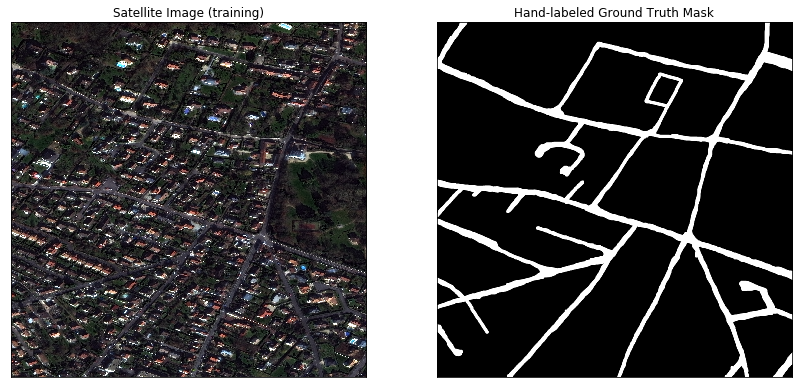

In [9]:
#plot image and ground truth 
plt.figure(figsize=(14,7))
plt.subplot(121),plt.imshow(Xtrain,cmap = 'gray')
plt.title('Satellite Image (training)'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(Ytrain,cmap = 'gray')
plt.title('Hand-labeled Ground Truth Mask'), plt.xticks([]), plt.yticks([])
plt.show()

# Logistic Regression

In [10]:
patch_size = 16
window_size = 72
pad = (window_size - patch_size) // 2
stride = 16
threshold = 0.25 # fraction of pixels > 1 for a patch to be labeled as a road foreground
C = 1e5 #Inverse of regularization strength in Logistic Regression

Let us define a function to get, for each RGB channel in an image patch, the mean color and standard deviation. These are our "features" (there are six of them per patch). We then define functions to train a logistic regression model and classify pixels in an new image. 

In [11]:
def get_features(img):
    """
    For each RGB channel in a patch calculate
    mean color and standard deviation
    """
    mean = np.mean(img, axis=(0,1))
    std = np.std(img, axis=(0,1))
    features = np.append(mean, std)
    return features

def train(model, Y, X):
    """Train this model."""

    # crop training and groud truth images into a list of patches
    patches = crop_3d(X, patch_size, patch_size, patch_size, 0)
    patches_gt = crop_2d(Y, patch_size, patch_size, patch_size)
    
    def binarize(vals):
        if np.sum(vals) > threshold:
            return 1
        return 0

    X = np.asarray([get_features(patches[i]) for i in range(len(patches))])
    X = PolynomialFeatures(4, interaction_only=False).fit_transform(X)
    X = StandardScaler().fit_transform(X)
    Y = np.asarray([binarize(np.mean(patches_gt[i])) 
                    for i in range(len(patches_gt))]) 
    model.fit(X, Y)
    print('Training done')

def classify(model, X):
    """
    Classify a test image after training model.
    Returns predictions as a list
    """
    patches = crop_3d(X, patch_size, patch_size, patch_size, 0) 
    X = np.asarray([get_features(patches[i]) for i in range(len(patches))])
    X = PolynomialFeatures(4, interaction_only=False).fit_transform(X)
    X = StandardScaler().fit_transform(X)
    
    Z = model.predict(X)
    
    # Regroup patches into images
    return Z.reshape(-1)

## Model Validation

We now calculate metrics such as accuracy, precision, etc on a validation set. We find that for inverse regularization C=0.5 in the Logistic Reg model, the F1 score is a bit larger.

Let us split the training data into two parts to train on a subset and validate on the other.  

In [12]:
linear_model.LogisticRegression?

Object `linear_model.LogisticRegression` not found.


In [13]:
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

model = linear_model.LogisticRegression(C=C)
#model = linear_model.LogisticRegression(C=C)

k_fold=4
seed=1

#train/validation split
np.random.seed(seed)
def split_indices(Y, k_fold, seed):
    """
    randomly split row indices into k_fold intervals for cross-validation.
    """
    interval = int(Y.shape[0] / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(Y.shape[0])
    k_indices = [indices[k*interval:(k+1)*interval] for k in range(k_fold)]
    return np.array(k_indices)

#get split
k_indices = split_indices(Ytrain, k_fold, seed)
non_k_indices = k_indices[np.arange(k_fold) != 0].ravel()

#apply to training image
x_tr = Xtrain[non_k_indices]
y_tr = Ytrain[non_k_indices]
x_te = Xtrain[k_indices[0]]
y_te = Ytrain[k_indices[0]]

#train model
train(model, y_tr, x_tr)

# Calculate ground-truth labels
y_true=[]
for p in crop_2d(y_te, patch_size, patch_size, stride):
    y_true.append(np.mean(p))
y_true = np.asarray(y_true) > threshold

Training done


/home/cyrfar/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:912: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Let us now calculate cross validation scores

In [14]:
def get_rates(ytest, ypred):
    '''get TP, FP, TN and FN rates'''
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(ypred)): 
        if ytest[i]==ypred[i]==1:
            TP += 1
        if ypred[i]==1 and ytest[i]!=ypred[i]:
            FP += 1
        if ytest[i]==ypred[i]==0:
            TN += 1
        if ypred[i]==0 and ytest[i]!=ypred[i]:
            FN += 1

    return(TP, FP, TN, FN)

#get cross validation rates
TP, FP, TN, FN = get_rates(y_true, classify(model, x_te))

#define metrics 
accuracy = (TP+TN)/(TP+FP+FN+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN) 
f1score = (2*precision*recall)/(precision + recall)

#display cross validation scores
print('accuracy = {},  precision = {}, recall = {}, f1 = {}'.format(accuracy, precision, recall, f1score))

accuracy = 0.9362561723776747,  precision = 0.3333333333333333, recall = 0.011876484560570071, f1 = 0.022935779816513763


## Model Predictions

Train the model

In [15]:
del model
model = linear_model.LogisticRegression(C=1e7)
#model = LinearSVC(C=1, loss ='hinge')
train(model, Ytrain, Xtrain)

Training done


/home/cyrfar/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:912: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We are now ready to make a prediction on the test image

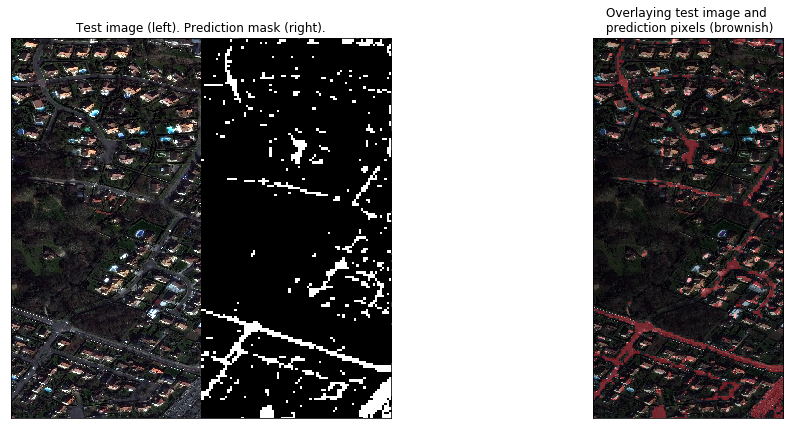

In [16]:
#make predictions
labels = classify(model, Xtest)
pred_mask = predict_mask(Xtest, patch_size, labels, stride)

#concatenate test image and predicted mask
concatenated_image = concatenate(Xtest, pred_mask)

#overlay test and ground truth
overlayed_image = overlay_images(Xtest, pred_mask)

#plot image and ground truth 
plt.figure(figsize=(16,7))
plt.subplot(121),plt.imshow(concatenated_image, cmap = 'gray')
plt.title('Test image (left). Prediction mask (right).'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(overlayed_image, cmap = 'gray')
plt.title('Overlaying test image and \n prediction pixels (brownish)'), plt.xticks([]), plt.yticks([])
plt.show()

# Appendix

Run this to get Xtrain after thresholding (you can ignore this section)

In [17]:
#convert to GrayScale
build_gray = cv.cvtColor(Xtrain, cv.COLOR_BGR2GRAY)

#apply thrsholding OTSU Thresholding
thresh = cv.threshold(build_gray, 128, 255,
        cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

#cv.imshow("Thresholded Image",thresh)
#cv.imwrite("image.jpg",thresh) 